In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as ticker

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

In [11]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [12]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
#Explore table measurement
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [15]:
#Explore table station
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [16]:
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

# Exploratory Climate Analysis

In [17]:
# Design a query to retrieve the last 12 months of precipitation data prior to your 
#trips start date and plot the results

# SOLUTION

# trip duration 07/01/2017 to 07/10/2017

# Calculate the date 1 year ago from trip start date

query_date = dt.datetime(2017, 7, 1) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the date and prcp values
sel = [Measurement.date,
       func.sum(Measurement.prcp)]
prcp_12mths = session.query(*sel).\
   filter(Measurement.date.between ('2016-07-01', '2017-07-01')).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

prcp_12mths

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(prcp_12mths, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)

# Sort the dataframe by date
df.sort_values('Date')
df.head()



Query Date:  2016-07-01 00:00:00


,Precipitation
Date,
2016-07-01,0.00
2016-07-02,0.00
2016-07-03,0.20
2016-07-04,0.48
2016-07-05,0.86


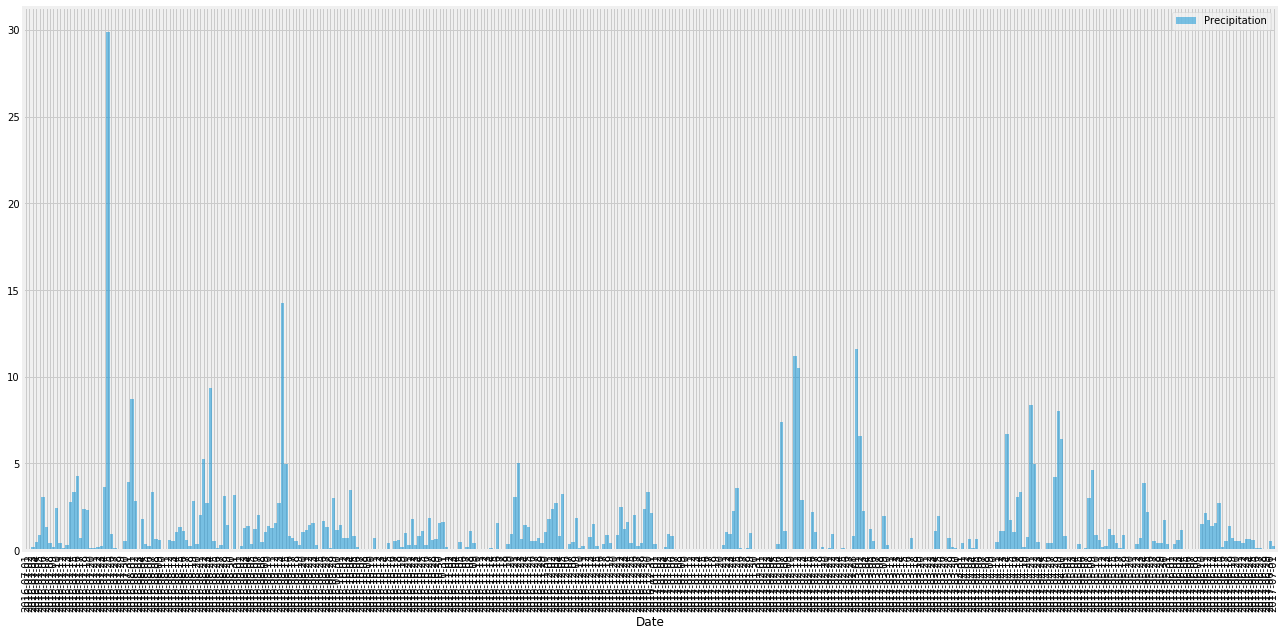

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
w=1
df.plot.bar(width=w, align='center', alpha=0.5,figsize=(20,10))

# Rotate the xticks for the dates
plt.xticks(rotation=90)
plt.show()  

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sel1 = [Measurement.prcp]
prcp = session.query(*sel1).all()
df_prcp = pd.DataFrame(prcp, columns=['Precipitation'])
df_prcp.describe()

,Precipitation
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [20]:
# How many stations are available in this dataset?
stations = session.query(Station).distinct(Station.station).count()
print(stations)

9


In [21]:
# What are the most active stations?
# List the stations and the counts in descending order.
sel2 = [Measurement.station,
    func.count(Measurement.tobs)]
active_station = session.query(*sel2).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

active_station


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel3 = [
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs),]
station_analysis = session.query(*sel3).\
   filter(Measurement.station == 'USC00519281').all()

station_analysis



[(54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data previous to your 
sel4 = [Measurement.tobs]
tobs_12mths = session.query(*sel4).\
   filter(Measurement.date.between ('2016-07-01', '2017-07-01')).\
   filter(Measurement.station == 'USC00519281').all()

tobs_12mths = pd.to_numeric(tobs_12mths, errors='coerce')

tobs_12mths

df2 = pd.DataFrame(tobs_12mths, columns=['Tobs'])
df2.head()

,Tobs
0,76
1,79
2,76
3,79
4,75


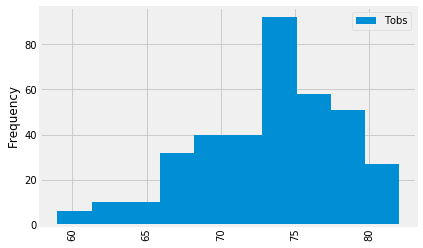

In [24]:
# trips start date for this station and plot the results as a histogram
w=1
df2.plot.hist()
# Rotate the xticks for the dates
plt.xticks(rotation=90)
plt.show()  

# Temperature Analysis (Optional)  

In [ ]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
